## Error Analysis

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19, DenseNet121

from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [2]:
BASE_PATH="C:/Users/HP/Downloads/case study2/DATASET2/"
filenames,labels = [],[]

for dirname in os.listdir(f'{BASE_PATH}TEST'):
    
    for file in os.listdir(f'{BASE_PATH}TEST/{dirname}'):
        filenames.append(BASE_PATH+"TEST/"+dirname+"/"+file)
        labels.append(dirname)
        
df_test = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

In [3]:
df_test.head()

,filename,labels
0,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog
1,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog
2,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog
3,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog
4,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog


In [4]:
def custom_model():
    cus_model = VGG19(input_shape = (256,256,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = Flatten()(cus_model.output)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(5, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

model=custom_model()
model.load_weights('yoga_model_vgg19_dropout_2.h5')

In [5]:
test_dir="C:/Users/HP/Downloads/case study2/DATASET2/TEST"
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(256,256),
                                                    shuffle=False)

Found 454 images belonging to 5 classes.


In [6]:
test_generator.class_indices

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [7]:
classes={0:'downdog',
 1:'goddess',
 2:'plank',
 3:'tree',
 4:'warrior2'}

In [8]:
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
df_test['predicted_pose']=y_pred
df_test['predicted_pose']=df_test['predicted_pose'].apply(lambda x: classes[int(x)])

In [9]:
df_test.head()

,filename,labels,predicted_pose
0,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,downdog
1,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,downdog
2,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,downdog
3,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,downdog
4,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,downdog


In [10]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    
    labels = ['downdog', 'goddess', 'plank','tree','warrior2']
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Number of misclassified points  3.0837004405286343
-------------------------------------------------- Confusion matrix --------------------------------------------------


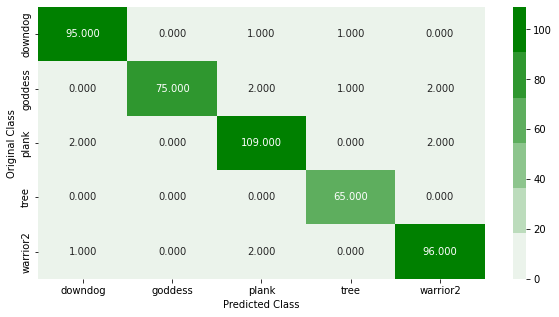

None


In [11]:
print(plot_confusion_matrix(test_generator.classes, y_pred))

In [12]:
downdog= df_test[df_test['labels']!=df_test['predicted_pose']]
downdog.head()

,filename,labels,predicted_pose
86,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,tree
88,C:/Users/HP/Downloads/case study2/DATASET2/TES...,downdog,plank
104,C:/Users/HP/Downloads/case study2/DATASET2/TES...,goddess,warrior2
130,C:/Users/HP/Downloads/case study2/DATASET2/TES...,goddess,plank
160,C:/Users/HP/Downloads/case study2/DATASET2/TES...,goddess,warrior2


In [13]:
downdog.iloc[0][2]

'tree'

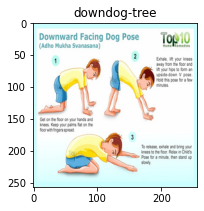

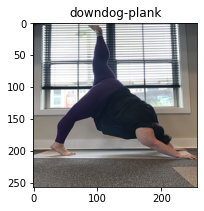

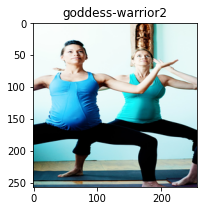

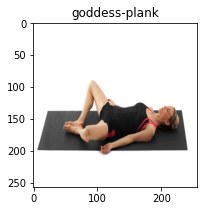

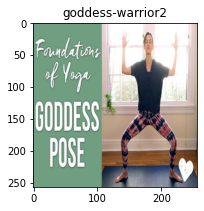

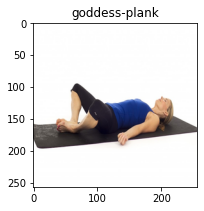

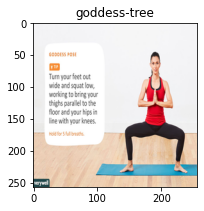

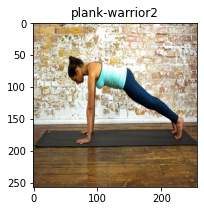

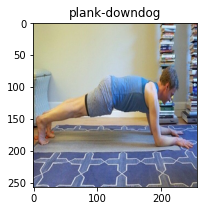

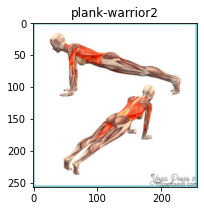

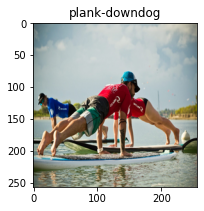

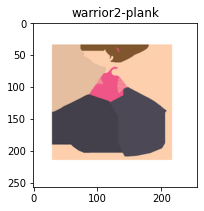

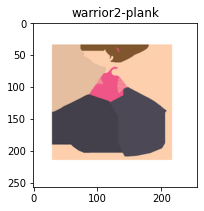

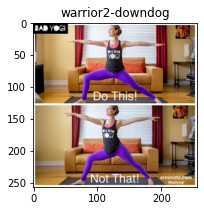

In [14]:
tot_im=len(downdog)
for i,file in enumerate(list(downdog['filename'])):
    img = Image.open(file).convert('RGB').resize((256, 256), Image.ANTIALIAS)
    plt.figure(figsize=(50,50))
    plt.subplot(tot_im,1,i+1)
    plt.imshow(img)
    pose=str(downdog.iloc[i][1]) +"-"+ str(downdog.iloc[i][2])
    plt.title(pose)

original--- downdog
predicted--- tree


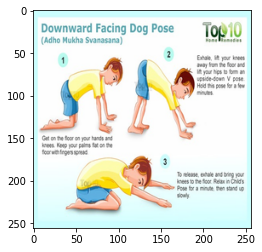

In [15]:
[path,original,predicted]=list(downdog.iloc[0])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. we can see that the image contain different poses and text.
2. so the model may be confused and predicted wrongly

original--- downdog
predicted--- plank


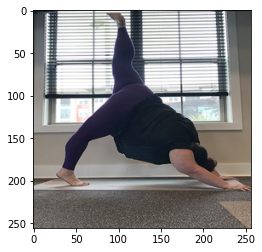

In [16]:
[path,original,predicted]=list(downdog.iloc[1])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. This pose looks more likely to plank, so model predicted as plank

original--- goddess
predicted--- warrior2


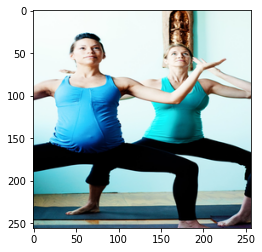

In [17]:
[path,original,predicted]=list(downdog.iloc[2])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. Both warrior and goddess poses are similar and differ in leg streches.
2. This image contains two people and are slightly overlapped, also one leg is not fully visible

original--- goddess
predicted--- plank


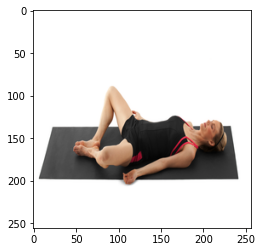

In [18]:
[path,original,predicted]=list(downdog.iloc[3])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. This is labelled as goddess but the pose is plank only
2. Also the used lyed on the mat so model predicted as plank.

original--- goddess
predicted--- warrior2


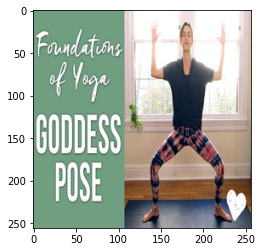

In [19]:
[path,original,predicted]=list(downdog.iloc[4])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. This image is goddess pose but predicted as warrior2

original--- goddess
predicted--- plank


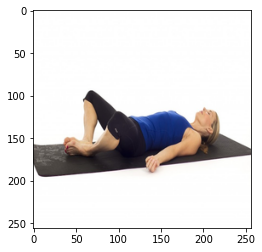

In [20]:
[path,original,predicted]=list(downdog.iloc[5])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. This is labelled as goddess but the pose is plank only
2. Also the used lyed on the mat so model predicted as plank.

original--- goddess
predicted--- tree


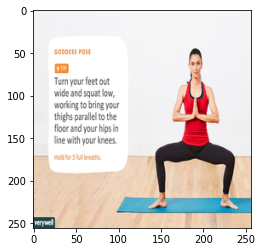

In [21]:
[path,original,predicted]=list(downdog.iloc[6])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. The image is predicted as tree.
2. The model might got confused because the user did namaskar, generally the tree contains namaskar in tree pose only.

original--- plank
predicted--- warrior2


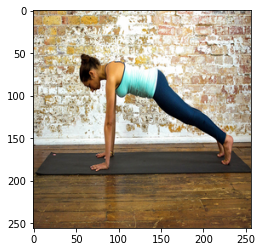

In [22]:
[path,original,predicted]=list(downdog.iloc[7])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. The model confused and predicted as warrior2

original--- plank
predicted--- downdog


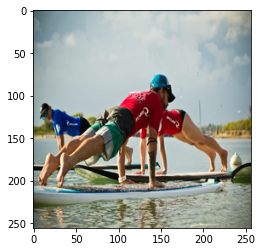

In [25]:
[path,original,predicted]=list(downdog.iloc[10])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. The image contains more poeple and are overlapped one above other, so model predicted as downdog

original--- warrior2
predicted--- plank


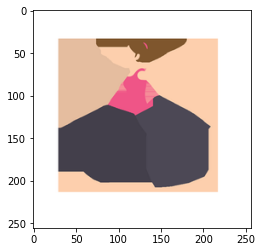

In [26]:
[path,original,predicted]=list(downdog.iloc[11])
img = Image.open(path).convert('RGB').resize((256, 256), Image.ANTIALIAS)
plt.imshow(img)
print("original---", original)
print("predicted---", predicted)

1. This is an outlier image

### Final Observations

1. The model was well trained and only few got misclassified.
2. Images with more people got misclassified.
3. There are some outlier images.
4. The model was slightly confused between goddess and warrior poses.

### How this can be improved

1. collecting more images with correct poses and withnsingle person.
2. lable images correctly.
3. Train images should not contain any text on it.